# Testing Navier-Stokes with a body in package `Whirl`

In [1]:
include(joinpath(Pkg.dir("Whirl"), "src/Whirl.jl"))
using Whirl

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

### Solve flow past a body

Set the flow parameters

In [3]:
Re = 200; # Reynolds number
U = 1.0; # Free stream velocity
U∞ = (U,0.0);

Set up points on the body

In [4]:
n = 51;
a = 0.5; b = 0.1;
body = Bodies.Plate(1.0,n)

Plate with 51 points and length 1.0 and thickness 0.0
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


Set the body motion. For now, make it stationary.

In [5]:
motion = RigidBodyMotion(0.0,0.0)

Rigid Body Motion:
  ċ = 0.0 + 0.0im
  c̈ = 0.0 + 0.0im
  α̇ = 0.0
  α̈ = 0.0
  Constant (ċ = 0.0 + 0.0im, α̇ = 0.0)

Transform the body with a specified initial position and orientation.

In [6]:
cent = 1.0+1.0im
α = 0.0 #-π/4
_,ċ,_,_,α̇,_ = motion(0.0)  # Additional 
T = RigidTransform(cent,α)
T(body) # transform the body to the current configuration
ds = Bodies.dlength(body); # we will need the arc lengths of each face on the body for later

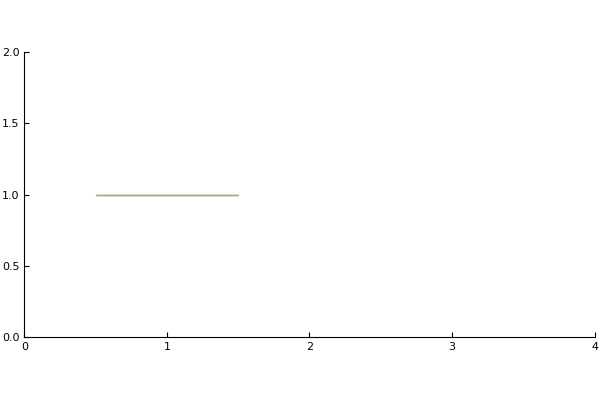

In [7]:
plot(body,xlim=(0,4),ylim=(0,2))

Or oscillatory pitch-heave kinematics

In [4]:
a = 0.25 # location of pitch axis, a = 0.5 is leading edge
ϕ = -π/2  # phase lag of pitch to heave
A = 0.25  # amplitude/chord
fstar = 1/π # fc/U
α₀ = 0 # mean angle of attack
Δα = 10π/180 # amplitude of pitching
U₀ = 0.0 # translational motion (set to zero in place of free stream)

K = π*fstar # reduced frequency, K = πfc/U

oscil = RigidBodyMotions.PitchHeave(U₀,a,K,ϕ,α₀,Δα,A);
motion = RigidBodyMotion(oscil)

Rigid Body Motion:
  ċ = 0.0 + 0.5im
  c̈ = -0.03 + 0.17im
  α̇ = 0.0
  α̈ = -0.7
  Oscillatory pitch-heave kinematics with
     Reduced frequency K = 1.0
     Heaving amplitude A = 0.25
     Pitching amplitude Δα = 0.17453292519943295
     Pitch-to-heave lag ϕ = -1.5707963267948966


Transform the body with a specified initial position and orientation.

In [5]:
cent = 1.0 + 1.0im
α = 0.0
_,ċ,_,_,α̇,_ = motion(0.0)  # Additional 
T = RigidTransform(cent,α)
T(body) # transform the body to the current configuration
ds = Bodies.dlength(body); # we will need the arc lengths of each face on the body for later

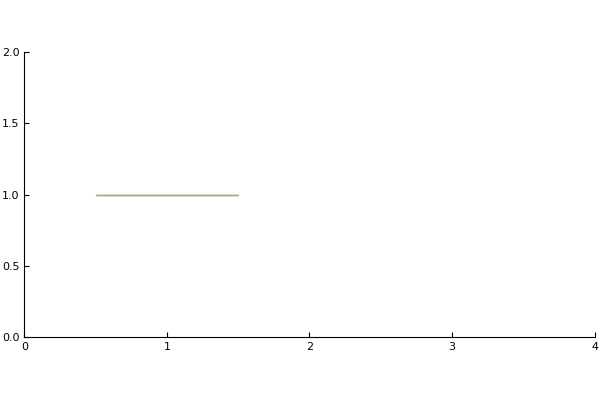

In [7]:
plot(body,xlim=(0,4),ylim=(0,2))

Now set up the coordinate data for operator construction

In [7]:
X = VectorData(body.x,body.y);
X̃ = VectorData(body.x̃,body.ỹ);

Set the domain size and time step size

In [8]:
nx = 202; ny = 102;
Ly = 2.0;
Δx = Ly/(ny-2);
Δt = min(0.5*Δx,0.5*Δx^2*Re);
w₀ = Nodes(Dual,(nx,ny));
xg, yg = coordinates(w₀,dx=Δx)

(-0.01:0.02:4.01, -0.01:0.02:2.0100000000000002)

### Now start constructing operators

#### Set up the state vector and constraint force vector for a static body

In [25]:
u = w₀
f = VectorData(X̃);
sys = Systems.NavierStokes((nx,ny),Re,Δx,Δt,U∞ = U∞, X̃ = X, isstore = true)

Navier-Stokes system on a grid of size 202 x 102

In [26]:
ifherk = IFHERK(u,f,sys.Δt,
                (t,u) -> Systems.plan_intfact(t,u,sys),
                (u,t) -> TimeMarching.plan_constraints(u,t,sys),
                ((u,t) -> Systems.r₁(u,t,sys),
                 (u,t) -> Systems.r₂(u,t,sys)),rk=TimeMarching.RK31,isstored=true)

Order-3 IF-HERK integrator with
   State of type Whirl.Fields.Nodes{Whirl.Fields.Dual,202,102}
   Force of type Whirl.Fields.VectorData{51}
   Time step size 0.01


In [27]:
t = 0.0
w₀ .= 0.0
u = deepcopy(w₀)
tf = 0.0;
T = 0:Δt:tf;
fx = Float64[];
fy = Float64[];
thist = Float64[];

In [42]:
@time for ti in T
    t, u, f = ifherk(t,u)
    push!(thist,t)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
end
println("solution completed through time t = ",t)

  0.074897 seconds (11.34 k allocations: 9.904 MiB, 8.32% gc time)
solution completed through time t = 0.09999999999999999


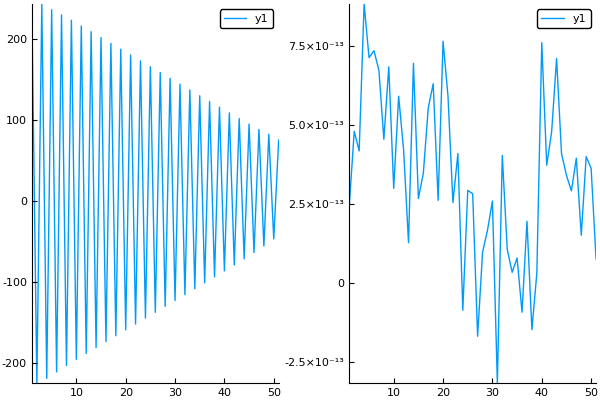

In [43]:
plot(plot(f.u),plot(f.v))

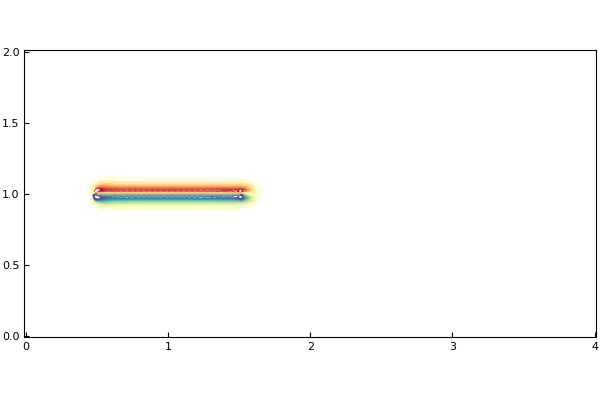

In [44]:
plot(xg,yg,u,levels=linspace(-0.5,0.5,30))
plot!(body)

#### Set up the state vector and constraint force vector for a moving body

In [10]:
u = (w₀,[real(cent),imag(cent),α])
f = (VectorData(X̃),Vector{Float64}());
sys = Systems.NavierStokes((nx,ny),Re,Δx,Δt,U∞ = U∞, X̃ = X̃, isstore = false, isstatic = false)

Navier-Stokes system on a grid of size 202 x 102

In [30]:
ifherk = IFHERK(u,f,sys.Δt,
                ((t,u) -> Systems.plan_intfact(t,u,sys),
                 (t,u) -> eye(3)),
                (u,t) -> TimeMarching.plan_constraints(u,t,sys),
                ((u,t) -> Systems.r₁(u,t,sys,motion),
                 (u,t) -> Systems.r₂(u,t,sys,motion)),tol=1e-2,rk=TimeMarching.RK31,isstored=false,isstaticconstraints=false)

Order-3 IF-HERK integrator with
   State of type Tuple{Whirl.Fields.Nodes{Whirl.Fields.Dual,202,102},Array{Float64,1}}
   Force of type Tuple{Whirl.Fields.VectorData{51},Array{Float64,1}}
   Time step size 0.01


In [31]:
t = 0.0
w₀ .= 0.0
u = (w₀,[real(cent),imag(cent),α])
f = (VectorData(X̃),Vector{Float64}());
tf = 0.0;
T = 0:Δt:tf;
fx = Float64[];
fy = Float64[];
thist = Float64[];

In [51]:
@time for ti in T
    t, u, f = ifherk(t,u)
    push!(thist,t)
    push!(fx,sum(f[1].u)*Δx^2)
    push!(fy,sum(f[1].v)*Δx^2)
end
println("solution completed through time t = ",t)

  7.732858 seconds (90.32 M allocations: 18.540 GiB, 21.46% gc time)
solution completed through time t = 0.09999999999999999


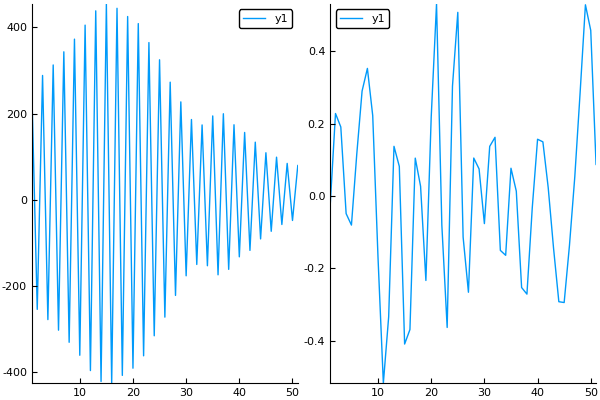

In [48]:
plot(plot(f[1].u),plot(f[1].v))

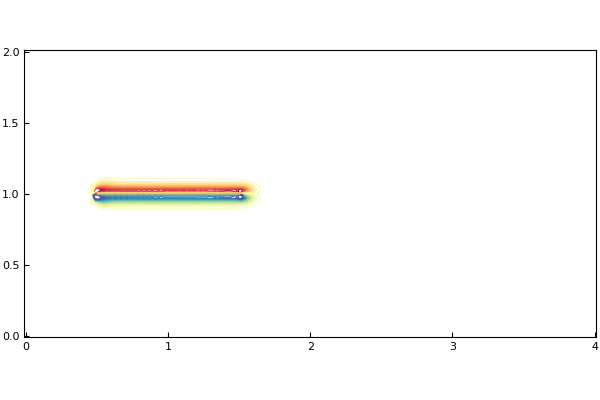

In [52]:
plot(xg,yg,u[1],levels=linspace(-0.5,0.5,30))
Tr = RigidTransform(u[2])
Tr(body) # transform the body to the current configuration
plot!(body)

In [14]:
t = 0.0
w₀ .= 0.0
w = deepcopy(w₀)
tf = 1
T = 0:Δt:tf;
fx = Float64[];
fy = Float64[];
thist = Float64[];

In [16]:
@time for ti in T
    t, w, f = ifherk(t,w)
    push!(thist,t)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
end
println("solution completed through time t = ",t)

  7.202874 seconds (1.83 M allocations: 1018.776 MiB, 3.06% gc time)
solution completed through time t = 1.0100000000000007


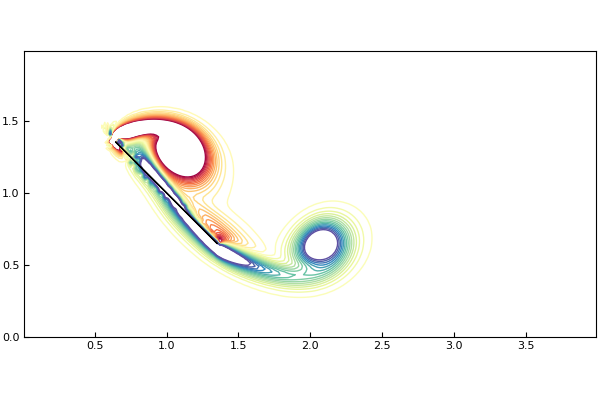

/Users/jeff/.julia/v0.6/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label'
  s)


In [17]:
xg,yg = coordinates(w,dx=Δx)
plot(xg,yg,w,trim=1,levels=linspace(-0.15,0.15,30))
plot!(body,fillcolor=:black,linecolor=:black)

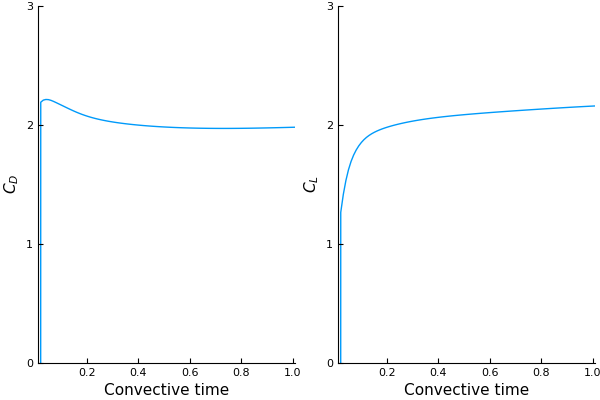

In [25]:
px = plot(thist,2*fx,ylim=(0,3),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
py = plot(thist,2*fy,ylim=(0,3),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot(px,py)

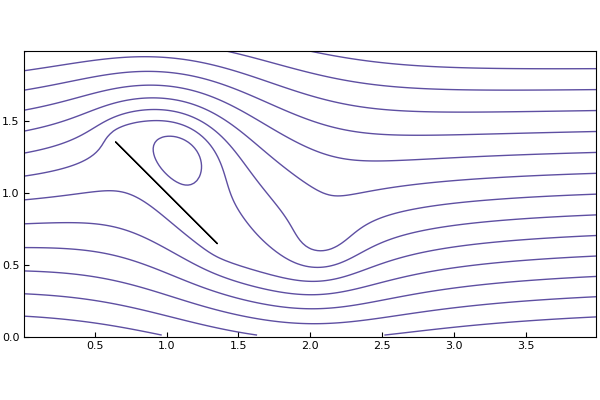

In [26]:
xg,yg = coordinates(w,dx=Δx)
ψ = deepcopy(w)
ψ .= -(sys.L\w)*Δx .+ repmat(collect(yg)',202,1)
plot(xg,yg,ψ,trim=1,clim=(-0.1,0.1))
plot!(body,fillcolor=:black,linecolor=:black)

In [5]:
regopfilter = Regularize(X,Δx;weights=ds,filter=true)
H̃mat = RegularizationMatrix(regopfilter,f,q);
Ẽmat = InterpolationMatrix(regopfilter,q,f);
P(f::VectorData) = Ẽmat*(H̃mat*f)